# First model - Price Processing
Aims:

- Process time series bitcoin data into tensors, usable by ML model
- Use hourly data, sourced from Binance exchange
- Create and run a proof of concept simple LSTM model

Data:

- From: 2017-08-17 04-AM 
- To: 2021-02-03 00:00:00
- 33,022 rows in CSV
- May be some duplicate entries - 1266 days = 30,384 hrs (2k+ less)
- Columns: unix, date, symbol, open, high, low, close, Volume BTC, Volume USDT, tradecount

| Column      | Example             |
| ----------- | ------------------- |
| unix        | 1612310400000       |
| date        | 2021-02-03 00:00:00 |
| symbol      | BTC/USDT            |
| open        | 35472.71            |
| high        | 35618.75            |
| low         | 35362.38            |
| close       | 35476.99            |
| Volume BTC  | 518.474918          |
| Volume USDT | 18393856.0883226    |
| tradecount  | 10423               |

- There is an increase in precision of data and inclusion of `tradecount` from `2020-08-01 23:00:00` on-wards.<img src="img/0-1-change-precision-and-date.png" style="border: 1px solid white;" />
- There is also a duplication of data between `2020-08-01 23:00:00` and `2020-11-20 07:00:00`, with there being entries for each hour in both the lower precision previous format and the higher precision new format
  - row 1790 to 7087<img src="img/0-2-end-duplication.png" style="border: 1px solid white;" />

I can either filter out these duplications somehow, or use the consistent data between `2017-08-17 04-AM ` and `2020-08-01 11-PM`

I will need to filter out and remove these duplications in the future, but for today I want to ensure I get through basic processing and target creation along with training a first model. If I have time I will return to creating a pandas script to delete these duplications later today, but for now I will just use the data up to `2020-08-01 11-PM`.

The change in precision of columns: `open, high, low, close, Volume BTC, Volume USDT` should not matter too much for `open, high, low, close` the precision only added 0s, no extra precision.  `Volume BTC, Volume USDT` did increase in precision by 4dp and 6dp respectively (both from 2dp). I am not certain, but I do not believe this should affect things much. As a precaution the new data could be reduced to 2dp before vectorisation to keep consistency.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

The truncated dataset between `2017-08-17 04-AM ` and `2020-08-01 11-PM` contains 25936 rows (excluding column title row)

In [2]:
current_folder = os.path.abspath('')
csv_file_path = os.path.join(current_folder, "Data", "Truncated_binance_1hr.csv")

# creating a pandas dataframe from CSV
df = pd.read_csv(csv_file_path)

# dataframe is sorted from newst to oldest, reverse order:
df = df[::-1]
df.shape

(25936, 10)

In [3]:
df.iloc[0]

unix               1502942400.0
date           2017-08-17 04-AM
symbol                 BTC/USDT
open                   16199.91
high                   16199.91
low                     4261.32
close                   4308.83
Volume BTC                44.51
Volume USDT           190952.85
tradecount                  NaN
Name: 25935, dtype: object

Plotting the close price of each sample to confirm data imported fine

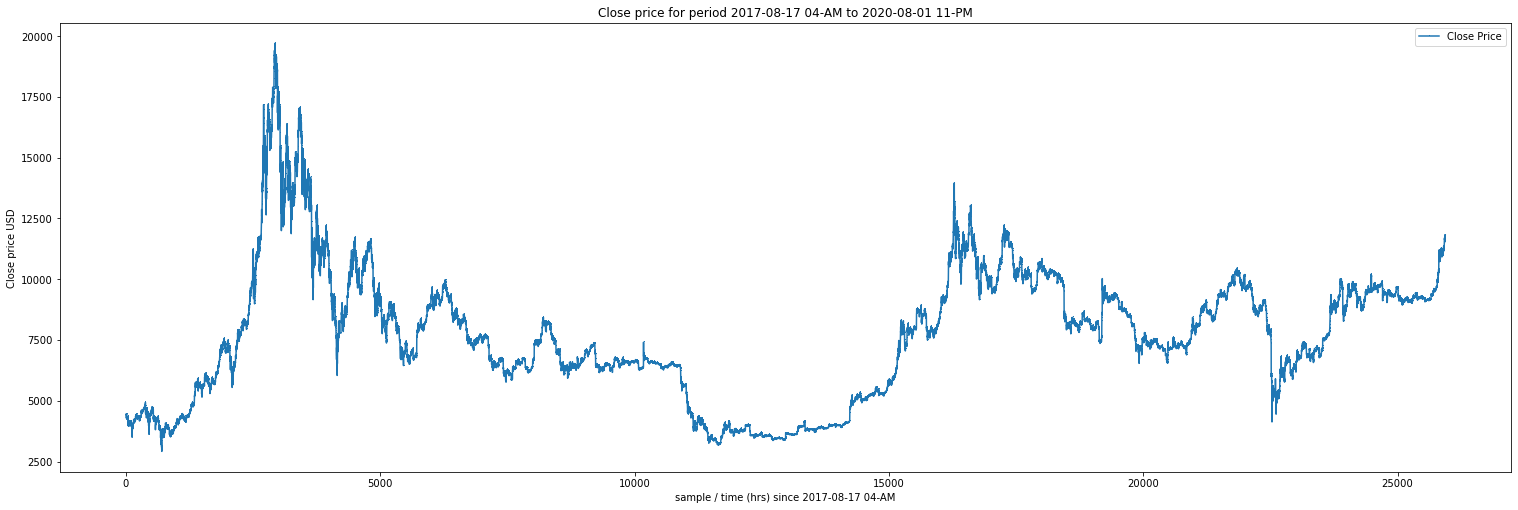

In [4]:
time_data = df["date"]
close_price = df["close"]
# setting witdth to 2x, so that figures can be side by side
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(22)
# plotting the training and validation loss
timesteps = range(1, len(time_data) + 1)
plt.plot(timesteps, close_price, '-,', label='Close Price')
plt.title("Close price for period 2017-08-17 04-AM to 2020-08-01 11-PM")
plt.xlabel('sample / time (hrs) since 2017-08-17 04-AM')
plt.ylabel('Close price USD')
plt.legend()
plt.tight_layout(pad=4.0)
plt.show()

In [5]:
# dropping volume USDT? seems like it equals [price * volumeBTC], probably redundant (could check after normalising data)
df = df.drop(columns=['unix', 'date', 'symbol', 'Volume USDT', 'tradecount'])
df.iloc[0]

open          16199.91
high          16199.91
low            4261.32
close          4308.83
Volume BTC       44.51
Name: 25935, dtype: float64

In [6]:
training_samples = 12000
validation_samples = 7000
test_samples = len(df) - (training_samples + validation_samples)  #5936
print(test_samples)

#setting values to end sample for each
validation_samples += training_samples
test_samples += validation_samples
print(f"final sample - training: {training_samples}th, validation: {validation_samples}th, test: {test_samples}th")

6936
final sample - training: 12000th, validation: 19000th, test: 25936th


In [7]:
# normalising data
mean = df[:training_samples].mean(axis=0)
df -= mean
std = df[:training_samples].std(axis=0)
df /= std

df.iloc[0]

open          2.868773
high          2.804907
low          -1.093977
close        -1.080245
Volume BTC   -1.008618
Name: 25935, dtype: float64

In [8]:
df.head()

,open,high,low,close,Volume BTC
25935,2.868773,2.804907,-1.093977,-1.080245,-1.008618
25934,-1.080411,-1.077008,-1.083815,-1.078089,-1.029751
25933,-1.078256,-1.071527,-1.077727,-1.075090,-1.045641
25932,-1.075257,-1.070043,-1.085154,-1.066574,-1.048411
25931,-1.066741,-1.060932,-1.069627,-1.063020,-1.051877


In [9]:
train_data = df[:training_samples]
val_data = df[training_samples:validation_samples]
test_data = df[validation_samples:]

print(len(train_data))
print(len(val_data))
print(len(test_data))

12000
7000
6936


In [10]:
df.iloc[0][3]

-1.080244816838616

In [11]:
lookback = 120 # 5 days, 24*5                       #past
step = 1    # no step initially                     #
delay = 24  # try make predictions 1 day from now   #future
batch_size = 128                                    #

In [12]:
# Setting up the training data
start = lookback + delay
end = start + training_samples

x_train = pd.DataFrame(train_data).to_numpy()
y_train = df.iloc[start:end, 3]
y_train = pd.DataFrame(y_train).to_numpy()

# print(len(x_train))
# print(x_train[0])
# print(x_train[start])
# print(len(y_train))
# print(y_train[0])

print("-----------------------------------------------------")
#setting up the validation dat
start = end 
end = start + 7000      #TODO: fix this mess
print(start)
print(end)

x_val = pd.DataFrame(val_data).to_numpy()
y_val = df.iloc[start:end, 3]
y_val = pd.DataFrame(y_val).to_numpy()

# print(len(x_val))
# print(x_val[0])
# print(x_val[lookback + delay])
# print(len(y_val))
# print(y_val[0])

print("-----------------------------------------------------")
# setting up test data
start = end
end = len(df)
print(start)
print(end)

x_test = pd.DataFrame(test_data).to_numpy()
x_test = x_test[:-(lookback + delay)]
y_test = df.iloc[start:end, 3]
y_test = pd.DataFrame(y_test).to_numpy()

# print(len(x_test))
# print(x_test[0])
# print(x_test[lookback + delay])
# print(len(y_test))
# print(y_test[0])

sequence_length = int(lookback / step) # in case change the step later

-----------------------------------------------------
12144
19144
-----------------------------------------------------
19144
25936


In [13]:
print(y_test[6791])
print(df.iloc[25935])

[1.40829417]
open          1.401959
high          1.372866
low           1.432459
close         1.408294
Volume BTC    1.126612
Name: 0, dtype: float64


In [18]:
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [19]:
for batch in train_dataset.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 120, 5)
Target shape: (128, 1)


In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = models.Sequential()
model.add(layers.GRU(32, input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
93/93 [==============================] - 17s 178ms/step - loss: 0.1766 - val_loss: 0.1112
Epoch 2/20
93/93 [==============================] - 16s 175ms/step - loss: 0.1126 - val_loss: 0.1056
Epoch 3/20
93/93 [==============================] - 17s 187ms/step - loss: 0.1094 - val_loss: 0.0974
Epoch 4/20
93/93 [==============================] - 17s 178ms/step - loss: 0.1081 - val_loss: 0.0935
Epoch 5/20
93/93 [==============================] - 18s 188ms/step - loss: 0.1072 - val_loss: 0.0914
Epoch 6/20
93/93 [==============================] - 17s 184ms/step - loss: 0.1067 - val_loss: 0.0902
Epoch 7/20
93/93 [==============================] - 17s 185ms/step - loss: 0.1064 - val_loss: 0.0891
Epoch 8/20
93/93 [==============================] - 18s 195ms/step - loss: 0.1061 - val_loss: 0.0877
Epoch 9/20
93/93 [==============================] - 17s 186ms/step - loss: 0.1058 - val_loss: 0.0870
Epoch 10/20
93/93 [==============================] - 18s 190ms/step - loss: 0.1058 - val_lo

In [ ]:
def plot_graphs(title):
    # setting witdth to 2x, so that figures can be side by side
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(11)
    
    # plotting the training and validation loss
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']

    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss:  ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout(pad=4.0)
    plt.show()

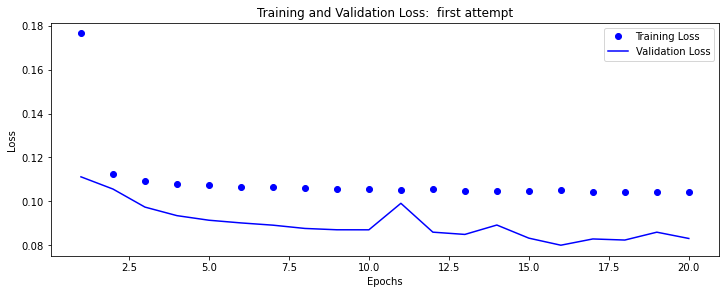

In [24]:
plot_graphs("first attempt")

In [39]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mae")
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 5)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [41]:
path_checkpoint = "model_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
32/93 [=========>....................] - ETA: 8s - loss: 0.3156

KeyboardInterrupt: 

In [ ]:
plot_graphs("copied model attempt")